<a href="https://colab.research.google.com/github/Alex112525/LangGraph-notebooks/blob/main/Routers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install langgraph langgraph-sdk langgraph-checkpoint-sqlite langsmith langchain-community langchain-core langchain-openai tavily-python wikipedia

In [2]:
import os
from google.colab import userdata
from IPython.display import Image, display

In [3]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_community.retrievers import TavilySearchAPIRetriever

In [4]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


In [5]:
os.environ["AZURE_OPENAI_API_KEY"] = userdata.get('Azure_openai')
os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get('Endpoint_openai')

## Utils Funtions

In [6]:
def get_model(model:str="DASH-mini", temp:float=0.1, max_tokens:int=100):
  """Get model from Azure OpenAI"""
  model = AzureChatOpenAI(
        openai_api_version="2024-02-15-preview",
        azure_deployment=model,
        temperature=temp,
        max_tokens=max_tokens,
    )
  return model

#### Tools

In [7]:
def sum(a:int, b:int) -> int:
  """Sum a and b

  Args:
    a: first number
    b: second number"""
  return a+b

def minus(a:int, b:int):
  """Minus a and b

  Args:
    a: first number
    b: second number"""
  return a-b

def multiply(a:int, b:int):
  """Multiply a and b

  Args:
    a: first number
    b: second number"""
  return a*b

def divide(a:int, b:int):
  """Divide a and b

  Args:
    a: first number
    b: second number"""
  return a/b if b != 0 else "We cannot divide by zero"

#### Model binding

__“binding”__ tools refers to the process of connecting or associating specific tools or functions with the model so that it can use them during its operations.

In [8]:
llm = get_model()
llm_with_tools = llm.bind_tools(
    tools=[sum, minus, multiply, divide]
)

In [9]:
def tool_calling_llm(state: MessagesState):
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

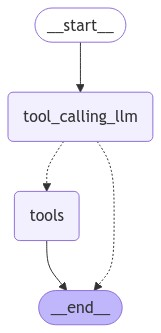

In [10]:
# Build Graph

builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([sum, minus, multiply, divide]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition) # If latest message is a tool Call -> routes Tool else routes END
builder.add_edge("tools", END)

graph = builder.compile()

#View graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
messages = [HumanMessage(content="What is 242+203")]
messages = graph.invoke({"messages": messages})
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

What is 242+203
================================== Ai Message ==================================
Tool Calls:
  sum (call_1mjUdHD7DAUjsiDItweI11hi)
 Call ID: call_1mjUdHD7DAUjsiDItweI11hi
  Args:
    a: 242
    b: 203
================================= Tool Message =================================
Name: sum

445


In [12]:
messages = [HumanMessage(content="What is 223-33")]
messages = graph.invoke({"messages": messages})
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

What is 223-33
================================== Ai Message ==================================
Tool Calls:
  minus (call_mxEy39g8bdDKu0tDecNskJyz)
 Call ID: call_mxEy39g8bdDKu0tDecNskJyz
  Args:
    a: 223
    b: 33
================================= Tool Message =================================
Name: minus

190


In [13]:
messages = [HumanMessage(content="What is 2223*20")]
messages = graph.invoke({"messages": messages})
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

What is 2223*20
================================== Ai Message ==================================
Tool Calls:
  multiply (call_VM7OqfRNyC5XNCIY8Ro35XtJ)
 Call ID: call_VM7OqfRNyC5XNCIY8Ro35XtJ
  Args:
    a: 2223
    b: 20
================================= Tool Message =================================
Name: multiply

44460


In [14]:
messages = [HumanMessage(content="What is 129823/65")]
messages = graph.invoke({"messages": messages})
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

What is 129823/65
================================== Ai Message ==================================
Tool Calls:
  divide (call_pyMJj5upBbj4AfTHmHxnX6yL)
 Call ID: call_pyMJj5upBbj4AfTHmHxnX6yL
  Args:
    a: 129823
    b: 65
================================= Tool Message =================================
Name: divide

1997.2769230769231


In [15]:
messages = [HumanMessage(content="Hello, How Are You?")]
messages = graph.invoke({"messages": messages})
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

Hello, How Are You?
================================== Ai Message ==================================

I'm just a program, but I'm here and ready to help you! How can I assist you today?
